In [71]:
import os
import pandas as pd
from config import config
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [72]:
def create_features(data):
    if data.index.dtype != 'datetime64[ns]':
        data['DateTime'] = data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['Day'].astype(str) + ' ' + data['ObsTime'].astype(str) + ':00:00'
        data['DateTime'] = pd.to_datetime(data['DateTime'])
        data.set_index('DateTime', inplace=True)

    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day
    data['ObsTime'] = data.index.hour
    data['DayofYear'] = data.index.dayofyear
    data['Quarter'] = data.index.quarter
    data['WeekofYear'] = data.index.isocalendar().week.astype('int')

    data = add_lags(data)
    return data

def add_lags(data):
    target_map = data['Temperature'].to_dict()
    for year in range(config['years_of_lag']):
        data[f'{year + 1} Year lag'] = (data.index - pd.DateOffset(years=year + 1)).map(target_map)
    return data

In [73]:
# df = pd.read_csv(os.path.join(config['path'], 'test_file.csv'))
df = pd.read_csv('test_file.csv')
df = create_features(df)
df

FileNotFoundError: [Errno 2] No such file or directory: 'test_file.csv'

In [ ]:
temp_data = df['Temperature']
temp_data.plot(style= '.',
               figsize=(15, 5),
               color=color_pal[0],
               title='Temperature in °C')
plt.show()
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

# Train data with Time Split

## Define Features and Target

In [74]:
FEATURES = ['Year', 'Month', 'Day', 'ObsTime', 'DayofYear', 'Quarter', 'WeekofYear', 'StnPres', 'RH', 'WS', 'WD',
            'Precp']
for i in range(config['years_of_lag']):
    FEATURES.append(f'{i+1} Year lag')
TARGET = ['Temperature']

In [75]:
from sklearn.metrics import mean_absolute_error
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    x_train = train[FEATURES]
    y_train = train[TARGET]

    x_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=90000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.001)
    reg.fit(x_train, y_train,
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=100)
    y_pred = reg.predict(x_test)
    preds.append(y_pred)
    score = mean_absolute_error(y_test, y_pred)
    # score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:23.69451	validation_1-rmse:23.97771
[100]	validation_0-rmse:21.47819	validation_1-rmse:21.75277
[200]	validation_0-rmse:19.47518	validation_1-rmse:19.73853
[300]	validation_0-rmse:17.66486	validation_1-rmse:17.91323
[400]	validation_0-rmse:16.02965	validation_1-rmse:16.26278
[500]	validation_0-rmse:14.55329	validation_1-rmse:14.76769
[600]	validation_0-rmse:13.22066	validation_1-rmse:13.41286
[700]	validation_0-rmse:12.01804	validation_1-rmse:12.19453
[800]	validation_0-rmse:10.93366	validation_1-rmse:11.09419
[900]	validation_0-rmse:9.95633	validation_1-rmse:10.10491
[1000]	validation_0-rmse:9.07616	validation_1-rmse:9.21366
[1100]	validation_0-rmse:8.28434	validation_1-rmse:8.41173
[1200]	validation_0-rmse:7.57245	validation_1-rmse:7.69097
[1300]	validation_0-rmse:6.93306	validation_1-rmse:7.03807
[1400]	validation_0-rmse:6.35941	validation_1-rmse:6.44993
[1500]	validation_0-rmse:5.84489	validation_1-rmse:5.91966
[1600]	validation_0-rmse:5.38365	validation_1-rms

In [76]:
scores

[1.5054695179691053,
 1.559191183129402,
 1.4520376086343914,
 1.9767270718317598,
 1.4956344902352112]

# Retrain on all data

In [77]:
Future_FEATURES = ['Year', 'Month', 'Day', 'ObsTime', 'Quarter', 'DayofYear', 'WeekofYear']
for i in range(config['years_of_lag']):
    Future_FEATURES.append(f'{i+1} Year lag')

## Train / Test Split

In [78]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

x_train = train[FEATURES]
y_train = train[TARGET]
x_test = test[FEATURES]
y_test = test[TARGET]


reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=90000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.0001,
                       subsample=1,
                       colsample_bytree=1,
                       reg_alpha=1)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:23.93236	validation_1-rmse:23.50596
[100]	validation_0-rmse:23.69699	validation_1-rmse:23.27657
[200]	validation_0-rmse:23.46397	validation_1-rmse:23.04974
[300]	validation_0-rmse:23.23329	validation_1-rmse:22.82529
[400]	validation_0-rmse:23.00492	validation_1-rmse:22.60307
[500]	validation_0-rmse:22.77885	validation_1-rmse:22.38305
[600]	validation_0-rmse:22.55505	validation_1-rmse:22.16527
[700]	validation_0-rmse:22.33350	validation_1-rmse:21.94980
[800]	validation_0-rmse:22.11417	validation_1-rmse:21.73650
[900]	validation_0-rmse:21.89704	validation_1-rmse:21.52533
[1000]	validation_0-rmse:21.68209	validation_1-rmse:21.31643
[1100]	validation_0-rmse:21.46929	validation_1-rmse:21.10966
[1200]	validation_0-rmse:21.25861	validation_1-rmse:20.90484
[1300]	validation_0-rmse:21.05004	validation_1-rmse:20.70201
[1400]	validation_0-rmse:20.84356	validation_1-rmse:20.50119
[1500]	validation_0-rmse:20.63915	validation_1-rmse:20.30235
[1600]	validation_0-rmse:20.43681	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=90000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [83]:
columns = ['max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'reg_alpha','MAE', 'RMSE', 'Run_Time']
col = pd.DataFrame(columns=columns)
replace = False
if replace:
    score_data = col
else:
    score_data = pd.read_csv(os.path.join(config['path'], 'score_data.csv'))
    score_data = pd.concat([score_data, col], ignore_index=True)
score_data.to_csv(os.path.join(config['path'], 'score_data.csv'), index=False)

In [82]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_absolute_error

depth = 3
rate = 0.001
sample = 1
colsample = 0.78
alpha = 800

print(f'Start training, max_depth = {depth}, learning_rate = {rate}, subsample = {sample}, colsample_bytree = {colsample}, reg_alpha = {alpha}\n')
start_time = time.time()
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=90000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',
                       max_depth=depth,
                       learning_rate=rate,
                       subsample=sample,
                       colsample_bytree=colsample,
                       reg_alpha=alpha)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
y_pred = reg.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
run_time = time.time() - start_time
row = {'max_depth': depth, 'learning_rate': rate, 'subsample': sample, 'colsample_bytree': colsample, 'reg_alpha': alpha,'MAE': mae, 'RMSE': rmse, 'Run_Time': run_time}
score_data = pd.read_csv(os.path.join(config['path'], 'score_data.csv'))
score_data = pd.concat([score_data, pd.DataFrame(row, index=[0])], ignore_index=True)
score_data.to_csv(os.path.join(config['path'], 'score_data.csv'), index=False)
score_data

Start training, max_depth = 3, learning_rate = 0.001, subsample = 1, colsample_bytree = 0.78, reg_alpha = 800

[0]	validation_0-rmse:23.91127	validation_1-rmse:23.48556
[100]	validation_0-rmse:21.68231	validation_1-rmse:21.31742
[200]	validation_0-rmse:19.66731	validation_1-rmse:19.35030
[300]	validation_0-rmse:17.84641	validation_1-rmse:17.56990
[400]	validation_0-rmse:16.20128	validation_1-rmse:15.96262
[500]	validation_0-rmse:14.71554	validation_1-rmse:14.51211
[600]	validation_0-rmse:13.37380	validation_1-rmse:13.20052
[700]	validation_0-rmse:12.16275	validation_1-rmse:12.01631
[800]	validation_0-rmse:11.07076	validation_1-rmse:10.95150
[900]	validation_0-rmse:10.08632	validation_1-rmse:9.99065
[1000]	validation_0-rmse:9.19962	validation_1-rmse:9.12854
[1100]	validation_0-rmse:8.40135	validation_1-rmse:8.35240
[1200]	validation_0-rmse:7.68372	validation_1-rmse:7.65578
[1300]	validation_0-rmse:7.03884	validation_1-rmse:7.03112
[1400]	validation_0-rmse:6.45996	validation_1-rmse:6.472

,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,MAE,RMSE,Run_Time,Rmse
0,3,0.00100,1.0,0.78,1000,1.458999,1.926574,301.789024,NaN
1,3,0.00100,1.0,0.78,10,1.502052,1.964919,130.657925,NaN
2,3,0.00100,1.0,0.78,200,1.487589,1.945199,136.088074,NaN
3,3,0.00100,1.0,0.78,100,1.483173,1.938839,131.015584,NaN
4,3,0.00100,1.0,0.78,100,1.483173,1.938839,131.207196,NaN
5,3,0.00100,0.9,0.78,100,1.498721,1.962973,207.502574,NaN
6,3,0.00100,1.0,0.78,100,1.483173,1.938839,135.879623,NaN
7,3,0.00100,1.0,0.70,100,1.479547,1.936060,141.297359,NaN
8,3,0.00100,1.0,0.60,100,1.493966,1.957612,129.223310,NaN
9,3,0.00100,1.0,0.80,100,1.541581,2.006364,83.406224,NaN


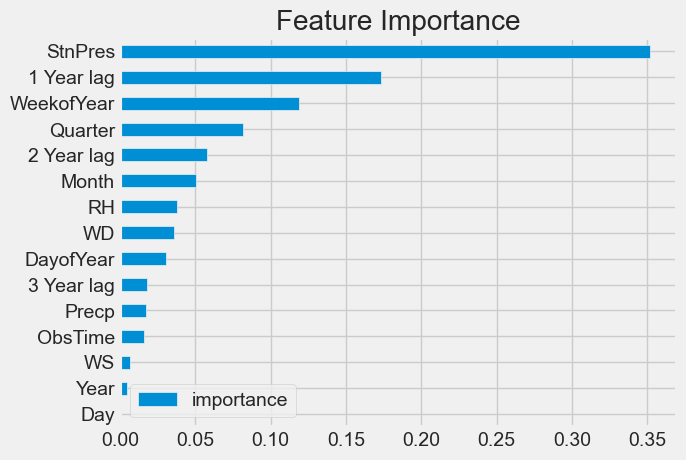

In [84]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                  index=FEATURES,
                                  columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
test['Prediction'] = reg.predict(x_test)
predict = round(test.pop('Prediction'), 2)
test.insert(5, 'Prediction', predict)
test

## retrain All Data

In [ ]:
x_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=90000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=1)
reg.fit(x_all, y_all,
        eval_set=[(x_all, y_all)],
        verbose=100)

In [ ]:
df.index.max()
# creating future dataframe
future = pd.date_range('2023-02-20', '2023-12-31', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future

In [ ]:
df_and_future = create_features(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features['WeekofYear'] = future_w_features['WeekofYear'].astype('int')


# predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[Future_FEATURES])

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1, lw=1,
                               title='Future Predictions')

In [ ]:
future_w_features.to_csv(os.path.join(config['path'], 'First_Prediction.csv'), index=False)
future_w_features

# Saving the Model

In [85]:
model = 'XGBoost'
reg.save_model(f'{model}_{depth}_{rate}_{sample}_{colsample}_{alpha}.json')

# Load the Model

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

# plotting the data

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Temperature'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold+1}')
    test['Temperature'].plot(ax=axs[fold],
                             label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()